#**자살충동 예측 모델연구 ** ( 보호 효과 분석을 위한 시뮬레이션 )





In [ ]:
import pandas as pd

train = pd.read_csv("/content/train.csv")


In [ ]:
df_student = train[train["Working Professional or Student"] == "Student"].copy()
df_worker  = train[train["Working Professional or Student"] == "Working Professional"].copy()

df_student.shape, df_worker.shape


((27901, 20), (112799, 20))

In [ ]:
df_student.info()
df_student['Gender'].value_counts(dropna=False)
df_student['Sleep Duration'].value_counts(dropna=False)
df_student["Degree"].value_counts(dropna=False)
df_student["Have you ever had suicidal thoughts ?"].value_counts(dropna=False)

Feature Selection

In [ ]:
student_features = [
    "Gender",
    "Sleep Duration",
    "Dietary Habits",
    "Degree",
    "Family History of Mental Illness",
    "Age",
    "Academic Pressure",
    "CGPA",
    "Study Satisfaction",
    "Work/Study Hours",
    "Financial Stress",
]

df_student_model = df_student[student_features + ["Have you ever had suicidal thoughts ?"]].copy()


In [ ]:
df_student_model["target"] = df_student_model["Have you ever had suicidal thoughts ?"].map({"Yes": 1, "No": 0})
df_student_model.drop(columns=["Have you ever had suicidal thoughts ?"], inplace=True)

In [ ]:
# 중앙값 치환
sleep_map = {
    "Less than 5 hours": 4,
    "5-6 hours": 5.5,
    "7-8 hours": 7.5,
    "More than 8 hours": 9
}

# mapping
df_student_model["Sleep Duration"] = df_student_model["Sleep Duration"].map(
    lambda x: sleep_map[x] if x in sleep_map else None
)

# none 값을 median으로 채움
df_student_model["Sleep Duration"] = df_student_model["Sleep Duration"].fillna(
    df_student_model["Sleep Duration"].median()
)


In [ ]:
# 숫자형 변수의 결측처리 : median
num_cols = [
    "Age",
    "Academic Pressure",
    "CGPA",
    "Study Satisfaction",
    "Work/Study Hours",
    "Financial Stress"
]

for col in num_cols:
    df_student_model[col] = df_student_model[col].fillna(df_student_model[col].median())

In [ ]:
df_student_model["Family History of Mental Illness"] = \
    df_student_model["Family History of Mental Illness"].map({"Yes": 1, "No": 0})

df_student_model["Gender"] = df_student_model["Gender"].map({"Male": 1, "Female": 0})
df_student_model = pd.get_dummies(df_student_model, columns=["Dietary Habits"], drop_first=True)

# Degree_ 고차원 one-hot 인코딩
df_student_model = pd.get_dummies(df_student_model, columns=["Degree"], drop_first=True)


In [ ]:
# X,y 분리
X = df_student_model.drop(columns=["target"])
y = df_student_model["target"]

from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
) # 불균형 데이터 처리


In [ ]:
import pandas as pd
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

# 예측
y_val_pred = log_clf.predict(X_val)
y_val_proba = log_clf.predict_proba(X_val)[:, 1]

# AUC
auc = roc_auc_score(y_val, y_val_proba)
df_auc = pd.DataFrame({"AUC": [auc]})

# Confusion Matrix
cm = confusion_matrix(y_val, y_val_pred)
df_cm = pd.DataFrame(
    cm,
    index=["Actual 0", "Actual 1"],
    columns=["Pred 0", "Pred 1"]
)

# Classification Report
report = classification_report(y_val, y_val_pred, output_dict=True)
df_report = pd.DataFrame(report).transpose()


display(df_auc)
display(df_cm)
display(df_report)


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report, confusion_matrix

# =====================================================
# 1. 시작: 원본 데이터 준비
# =====================================================
df = df_student_model.copy()

# =====================================================
# 2. 숫자 결측치 처리
# =====================================================
num_cols = ["Age", "Academic Pressure", "CGPA", "Study Satisfaction",
            "Work/Study Hours", "Financial Stress"]

for col in num_cols:
    df[col] = df[col].fillna(df[col].median())

# =====================================================
# 3. FEATURE ENGINEERING
# =====================================================

# 3-1) Total Stress
df["TotalStress"] = df["Academic Pressure"] + df["Financial Stress"]

# 3-2) Sleep Duration numeric transform
sleep_map = {
    "Less than 5 hours": 4,
    "5-6 hours": 5.5,
    "7-8 hours": 7.5,
    "More than 8 hours": 9
}

if "Sleep Duration" in df.columns:
    df["SleepDuration_num"] = df["Sleep Duration"].map(lambda x: sleep_map.get(x, np.nan))
else:
    df["SleepDuration_num"] = df["SleepDuration_num"]  # 혹시 이미 있을 경우 유지

df["SleepDuration_num"] = df["SleepDuration_num"].fillna(df["SleepDuration_num"].median())

# Sleep binary features
df["Sleep_short"] = (df["SleepDuration_num"] < 7).astype(int)
df["Sleep_long"] = (df["SleepDuration_num"] >= 8).astype(int)

# 3-3) Study Satisfaction × Stress
df["StudyStress_inter"] = df["Study Satisfaction"] * df["TotalStress"]

# 3-4) Age Group
def age_group(x):
    if x < 18:
        return "teen"
    elif x < 25:
        return "20s"
    elif x < 35:
        return "30s"
    else:
        return "40+"

df["AgeGroup"] = df["Age"].apply(age_group)

# 3-5) Log transform
df["LogHours"] = np.log1p(df["Work/Study Hours"])

# =====================================================
# 4. 인코딩 (중복 방지)
# =====================================================

# Gender / FamilyHistory simple encoding
if df["Gender"].dtype == "object":
    df["Gender"] = df["Gender"].map({"Male": 1, "Female": 0})

if df["Family History of Mental Illness"].dtype == "object":
    df["Family History of Mental Illness"] = \
        df["Family History of Mental Illness"].map({"Yes": 1, "No": 0})

# One-hot encoding only if those columns exist
dummy_cols = []
for col in ["Dietary Habits", "Degree", "AgeGroup"]:
    if col in df.columns:
        dummy_cols.append(col)

if dummy_cols:
    df = pd.get_dummies(df, columns=dummy_cols, drop_first=True)

# =====================================================
# 5. X, y 구성
# =====================================================

# Sleep Duration 원본 컬럼 제거
drop_cols = ["target"]
if "Sleep Duration" in df.columns:
    drop_cols.append("Sleep Duration")

X = df.drop(columns=drop_cols)
y = df["target"]

# =====================================================
# 6. Train/Validation Split
# =====================================================

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# =====================================================
# 7. XGBoost 모델
# =====================================================

xgb_fe = XGBClassifier(
    n_estimators=500,
    max_depth=5,
    learning_rate=0.04,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="auc",
    n_jobs=-1,
    random_state=42
)

xgb_fe.fit(X_train, y_train)

# =====================================================
# 8. 평가
# =====================================================

y_pred = xgb_fe.predict(X_val)
y_proba = xgb_fe.predict_proba(X_val)[:, 1]

auc_fe = roc_auc_score(y_val, y_proba)
acc_fe = accuracy_score(y_val, y_pred)
report_fe = classification_report(y_val, y_pred, output_dict=True)
cm_fe = confusion_matrix(y_val, y_pred)

df_auc_acc = pd.DataFrame({"AUC": [auc_fe], "Accuracy": [acc_fe]})
df_cm = pd.DataFrame(cm_fe, index=["Actual 0", "Actual 1"], columns=["Pred 0", "Pred 1"])
df_report = pd.DataFrame(report_fe).transpose()

display(df_auc_acc)
display(df_cm)
display(df_report)


# 보호효과 시뮬레이션

학생 그룹 보호효과 분석


,Scenario,Baseline Risk (%),Intervention Risk (%),Risk Reduction (%),High Risk Count (Before),High Risk Count (After),High Risk Reduction (%),Protective Effect Index
0,stress_reduction,63.297989,46.144337,27.099836,4124,2100,49.078565,270.998352
1,sleep_improvement,63.297989,64.265007,-1.527726,4124,4208,-2.036857,-15.277261
2,healthy_diet,63.297989,58.362175,7.797741,4124,3734,9.456838,77.977409
3,work_life_balance,63.297989,61.330849,3.107742,4124,3971,3.709990,31.077419
4,satisfaction_boost,63.297989,63.297989,0.000000,4124,4124,0.000000,0.000000
5,comprehensive,63.297989,41.242130,34.844482,4124,1337,67.580019,348.444824


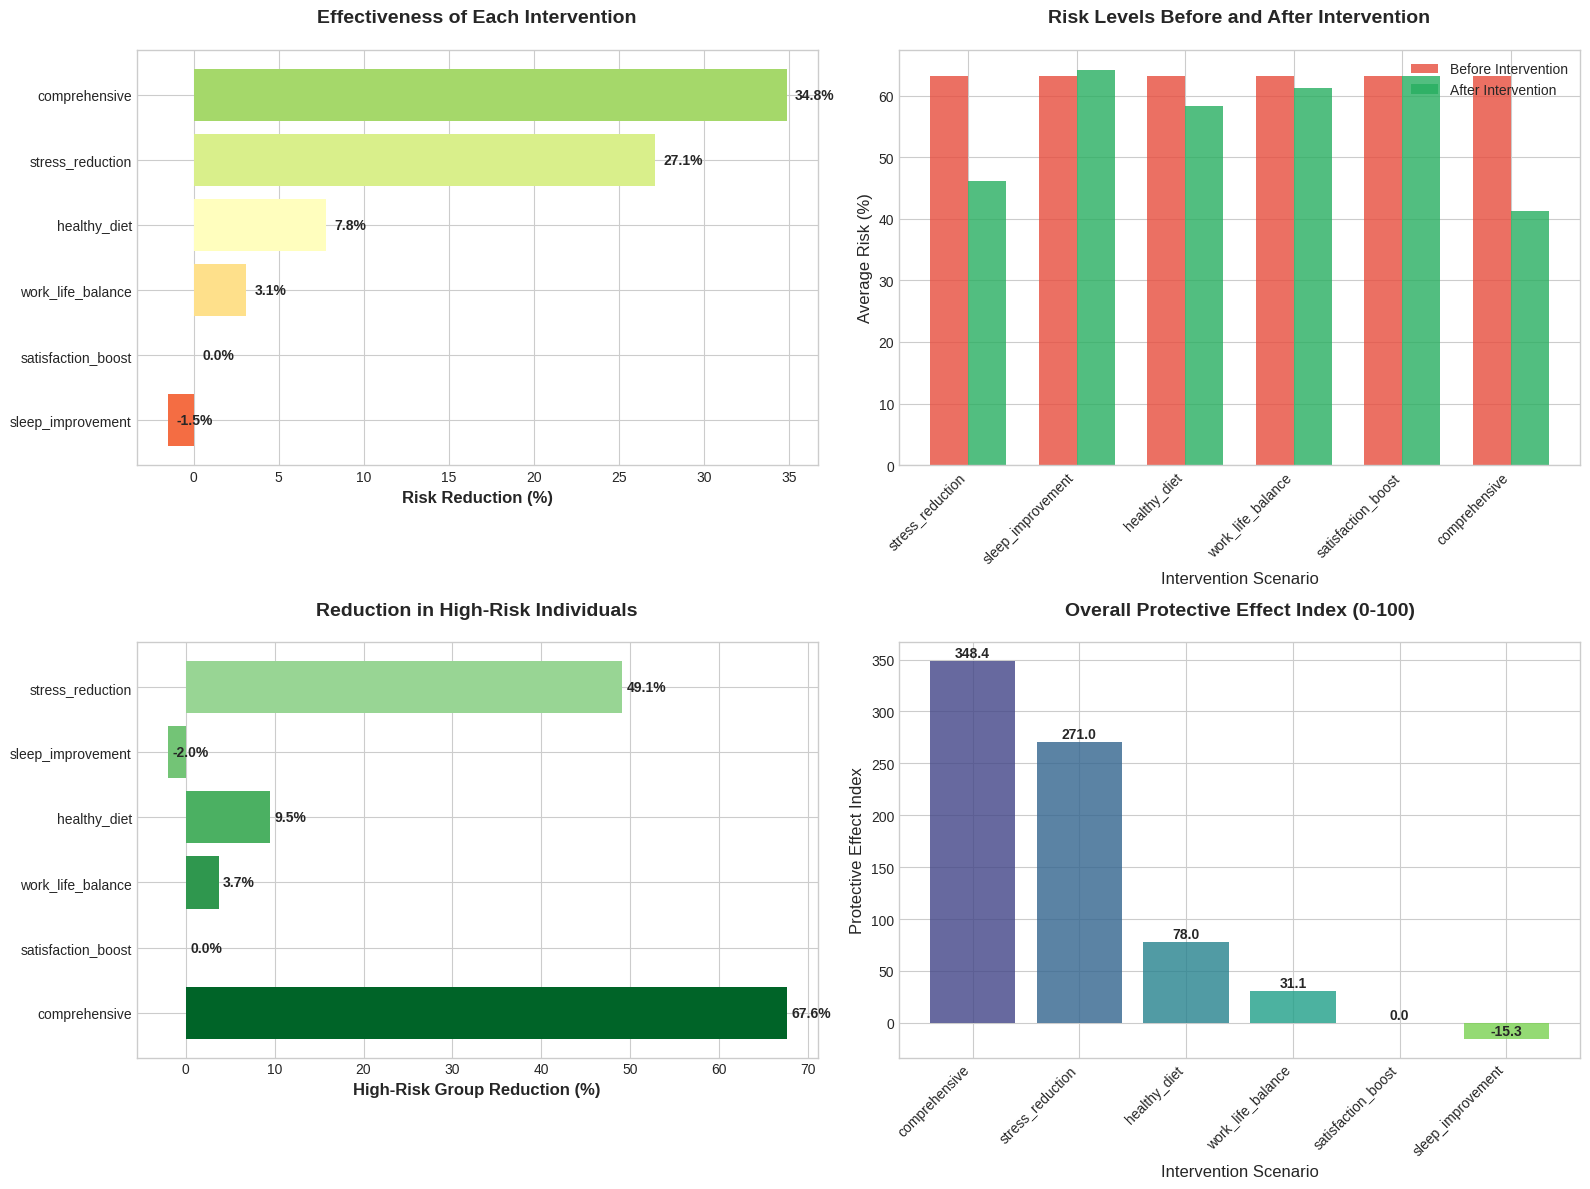


종합 개입 시나리오 - 개인별 위험도 변화 (상위 100명)


,Original_Risk,Intervention_Risk,Risk_Reduction,Risk_Reduction_Pct
1607,0.785752,0.224120,0.561632,71.477005
2872,0.846824,0.327845,0.518979,61.285313
212,0.852301,0.353598,0.498703,58.512581
1045,0.855212,0.357219,0.497992,58.230324
696,0.884362,0.389032,0.495329,56.009842
1155,0.817388,0.324788,0.492600,60.265106
2271,0.795354,0.302894,0.492460,61.917049
1160,0.846086,0.357390,0.488696,57.759605
3461,0.820983,0.333894,0.487089,59.329945
3089,0.803725,0.319210,0.484515,60.283695


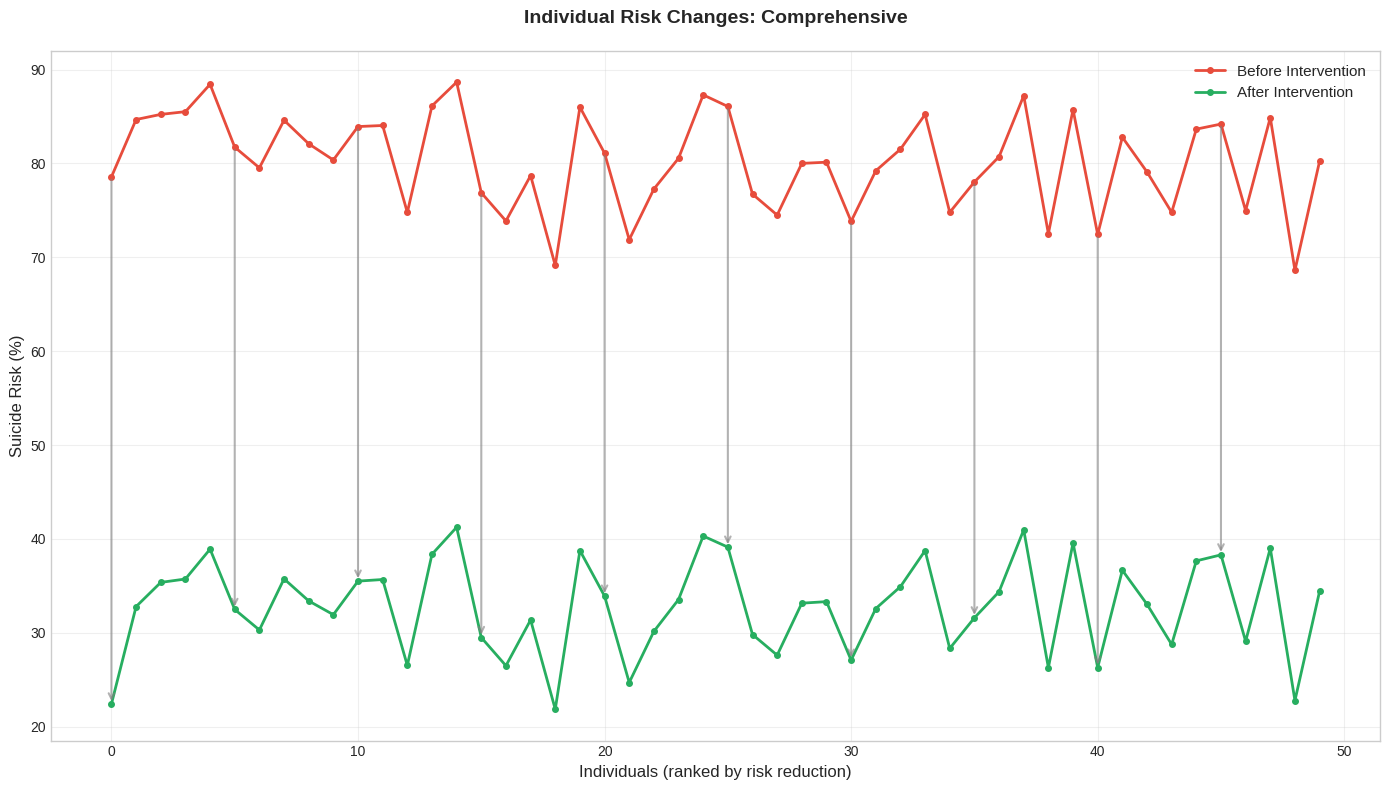


직장인 그룹 보호효과 분석


,Scenario,Baseline Risk (%),Intervention Risk (%),Risk Reduction (%),High Risk Count (Before),High Risk Count (After),High Risk Reduction (%),Protective Effect Index
0,stress_reduction,46.187843,43.959446,4.824646,4184,3046,27.198853,48.246460
1,sleep_improvement,46.187843,45.896370,0.631066,4184,4010,4.158700,6.310658
2,healthy_diet,46.187843,44.051361,4.625641,4184,2905,30.568834,46.256409
3,work_life_balance,46.187843,45.923164,0.573052,4184,4033,3.608987,5.730520
4,satisfaction_boost,46.187843,46.187843,0.000000,4184,4184,0.000000,0.000000
5,comprehensive,46.187843,41.580204,9.975875,4184,1611,61.496176,99.758751


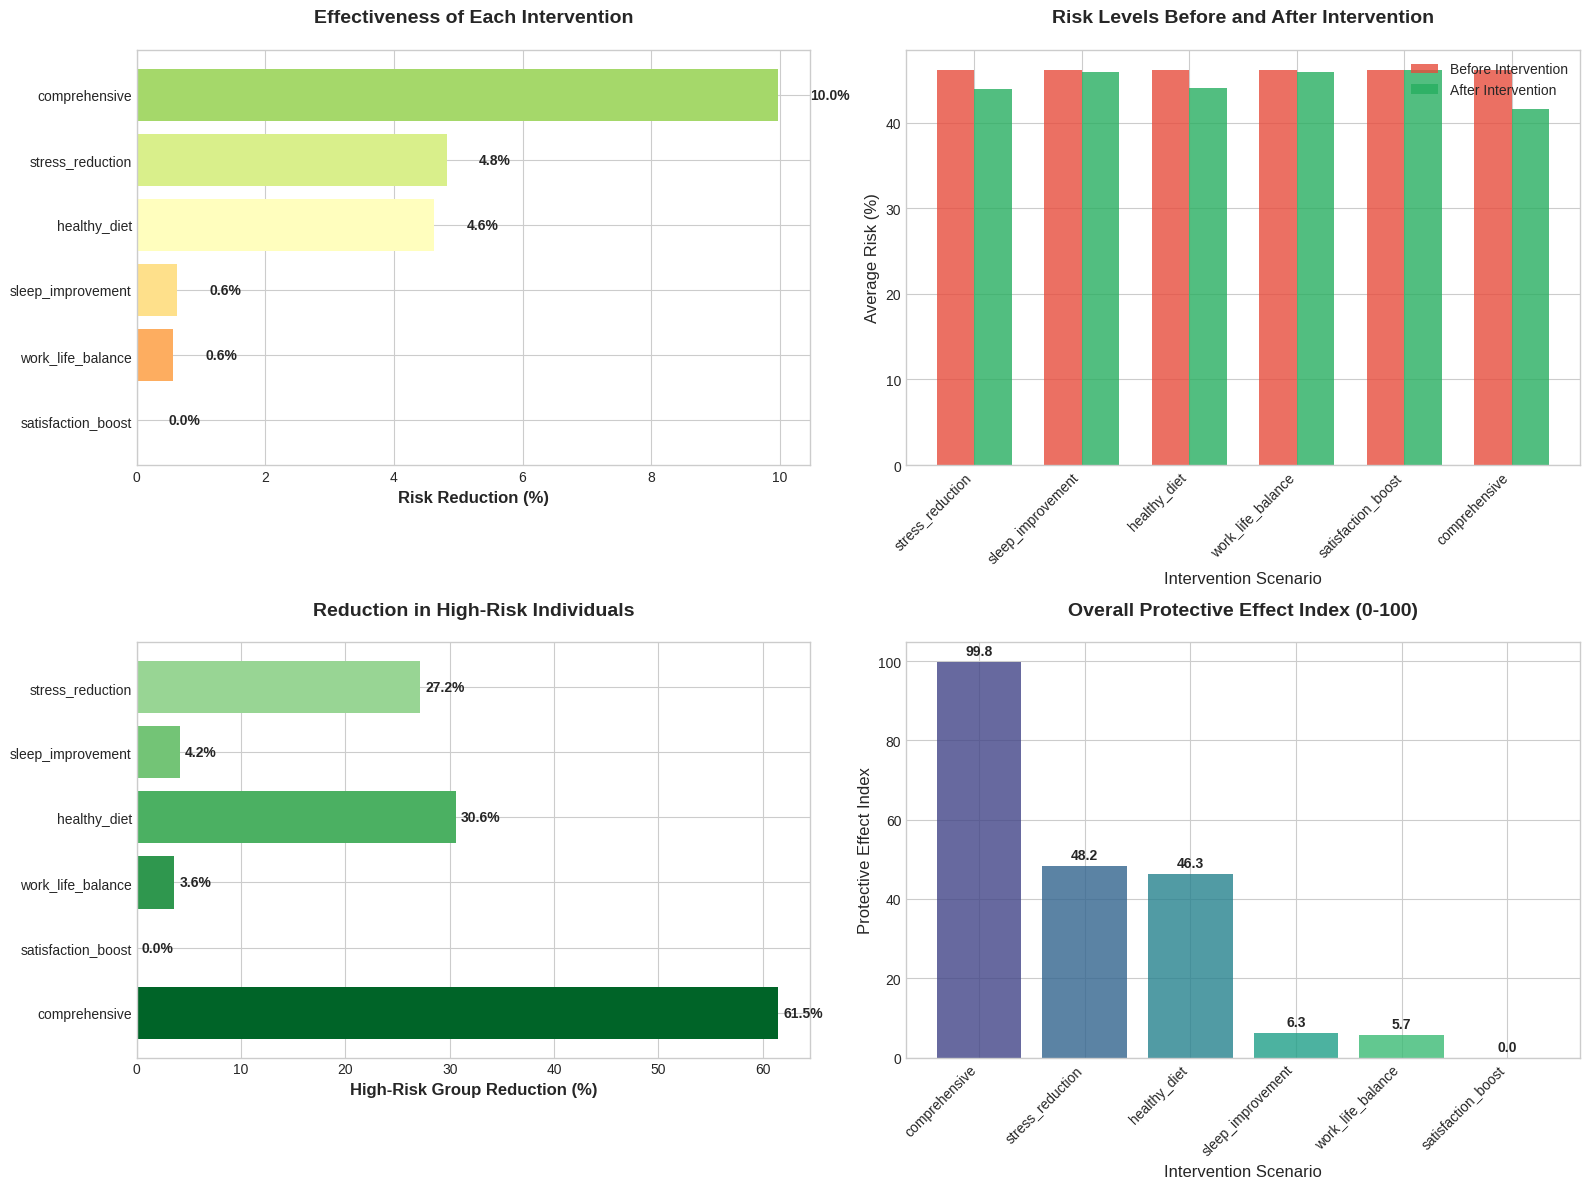


주요 발견 및 정책 권고사항

1. 가장 효과적인 단일 개입: comprehensive
   - 위험도 감소율: 34.84%
   - 고위험군 감소: 67.58%
   - 보호효과 지수: 348.44

2. 종합 개입 프로그램 효과:
   - 여러 개입을 동시에 실시할 경우 시너지 효과 발생
   - 개인별 맞춤 개입 전략 필요

3. 정책 제안:
   - 고위험군 선별 및 집중 관리 시스템 구축
   - 스트레스 관리 프로그램 제공
   - 수면 위생 교육 및 환경 개선
   - 일-생활 균형 정책 시행
   - 정기적 만족도 모니터링 및 상담 지원



In [ ]:
# ============================================
# 보호효과 분석: 개입 시뮬레이션
# ============================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score

# ============================================
# 1. 개입 시나리오 정의 함수
# ============================================
def create_intervention_scenarios(X_original, scenario_name="default"):
    """
    특정 변수를 개선한 시나리오 데이터를 생성

    Parameters:
    - X_original: 원본 데이터프레임
    - scenario_name: 개입 시나리오 이름

    Returns:
    - X_modified: 개입이 적용된 데이터프레임
    """
    X_modified = X_original.copy()

    if scenario_name == "stress_reduction":
        # 스트레스 30% 감소
        if "Academic Pressure" in X_modified.columns:
            X_modified["Academic Pressure"] = X_modified["Academic Pressure"] * 0.7
        if "Financial Stress" in X_modified.columns:
            X_modified["Financial Stress"] = X_modified["Financial Stress"] * 0.7
        if "Work Pressure" in X_modified.columns:
            X_modified["Work Pressure"] = X_modified["Work Pressure"] * 0.7

    elif scenario_name == "sleep_improvement":
        # 수면시간을 7-8시간으로 개선
        if "Sleep Duration" in X_modified.columns:
            X_modified["Sleep Duration"] = 7.5

    elif scenario_name == "healthy_diet":
        # 건강한 식습관으로 변경
        if "Dietary Habits_Unhealthy" in X_modified.columns:
            X_modified["Dietary Habits_Unhealthy"] = 0
        if "Dietary Habits_Healthy" in X_modified.columns:
            X_modified["Dietary Habits_Healthy"] = 1

    elif scenario_name == "work_life_balance":
        # 근로/학습 시간 20% 감소
        if "Work/Study Hours" in X_modified.columns:
            X_modified["Work/Study Hours"] = X_modified["Work/Study Hours"] * 0.8

    elif scenario_name == "satisfaction_boost":
        # 만족도 20% 증가
        if "Study Satisfaction" in X_modified.columns:
            max_val = X_modified["Study Satisfaction"].max()
            X_modified["Study Satisfaction"] = np.minimum(
                X_modified["Study Satisfaction"] * 1.2, max_val
            )
        if "Job Satisfaction" in X_modified.columns:
            max_val = X_modified["Job Satisfaction"].max()
            X_modified["Job Satisfaction"] = np.minimum(
                X_modified["Job Satisfaction"] * 1.2, max_val
            )

    elif scenario_name == "comprehensive":
        # 종합 개입: 위의 모든 개입을 동시에 적용
        X_modified = create_intervention_scenarios(X_modified, "stress_reduction")
        X_modified = create_intervention_scenarios(X_modified, "sleep_improvement")
        X_modified = create_intervention_scenarios(X_modified, "healthy_diet")
        X_modified = create_intervention_scenarios(X_modified, "work_life_balance")
        X_modified = create_intervention_scenarios(X_modified, "satisfaction_boost")

    return X_modified


# ============================================
# 2. 보호효과 지수 계산 함수
# ============================================
def calculate_protective_effect(model, X_val, y_val, scenario_list):
    """
    각 개입 시나리오별 보호효과 계산

    Returns:
    - results_df: 시나리오별 결과 요약 데이터프레임
    """
    # 원본 예측
    y_proba_original = model.predict_proba(X_val)[:, 1]
    baseline_risk = y_proba_original.mean()
    high_risk_original = (y_proba_original >= 0.5).sum()

    results = []

    for scenario in scenario_list:
        # 개입 적용
        X_intervention = create_intervention_scenarios(X_val, scenario)

        # 개입 후 예측
        y_proba_intervention = model.predict_proba(X_intervention)[:, 1]
        intervention_risk = y_proba_intervention.mean()
        high_risk_intervention = (y_proba_intervention >= 0.5).sum()

        # 보호효과 계산
        risk_reduction = baseline_risk - intervention_risk
        risk_reduction_pct = (risk_reduction / baseline_risk) * 100

        # 고위험군 감소
        high_risk_reduction = high_risk_original - high_risk_intervention
        high_risk_reduction_pct = (high_risk_reduction / high_risk_original) * 100 if high_risk_original > 0 else 0

        # 보호효과 지수 (0-100 척도)
        protective_index = risk_reduction_pct * 10  # 스케일 조정

        results.append({
            "Scenario": scenario,
            "Baseline Risk (%)": baseline_risk * 100,
            "Intervention Risk (%)": intervention_risk * 100,
            "Risk Reduction (%)": risk_reduction_pct,
            "High Risk Count (Before)": high_risk_original,
            "High Risk Count (After)": high_risk_intervention,
            "High Risk Reduction (%)": high_risk_reduction_pct,
            "Protective Effect Index": protective_index
        })

    return pd.DataFrame(results)


# ============================================
# 3. 개인별 위험도 변화 분석
# ============================================
def analyze_individual_risk_change(model, X_val, scenario_name, top_n=100):
    """
    개입 전후 개인별 위험도 변화 분석

    Returns:
    - risk_change_df: 위험도 변화가 큰 순서대로 정렬된 데이터프레임
    """
    # 원본 예측
    y_proba_original = model.predict_proba(X_val)[:, 1]

    # 개입 후 예측
    X_intervention = create_intervention_scenarios(X_val, scenario_name)
    y_proba_intervention = model.predict_proba(X_intervention)[:, 1]

    # 변화량 계산
    risk_change = y_proba_original - y_proba_intervention
    risk_change_pct = (risk_change / y_proba_original) * 100

    # 데이터프레임 생성
    risk_change_df = pd.DataFrame({
        "Original_Risk": y_proba_original,
        "Intervention_Risk": y_proba_intervention,
        "Risk_Reduction": risk_change,
        "Risk_Reduction_Pct": risk_change_pct
    })

    # 위험도 감소가 큰 순서대로 정렬
    risk_change_df = risk_change_df.sort_values("Risk_Reduction", ascending=False)

    return risk_change_df.head(top_n)


# ============================================
# 4. 시각화 함수
# ============================================
def plot_protective_effects(results_df):
    """보호효과 시각화"""
    plt.style.use('seaborn-v0_8-whitegrid')

    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    # (1) 위험도 감소율 바차트
    ax1 = axes[0, 0]
    scenario_order = results_df.sort_values("Risk Reduction (%)", ascending=False)
    colors = plt.cm.RdYlGn_r(np.linspace(0.3, 0.8, len(scenario_order)))

    bars = ax1.barh(scenario_order["Scenario"], scenario_order["Risk Reduction (%)"], color=colors)
    ax1.set_xlabel("Risk Reduction (%)", fontsize=12, fontweight='bold')
    ax1.set_title("Effectiveness of Each Intervention", fontsize=14, fontweight='bold', pad=20)
    ax1.invert_yaxis()

    # 수치 표시
    for i, (bar, val) in enumerate(zip(bars, scenario_order["Risk Reduction (%)"])):
        ax1.text(val + 0.5, bar.get_y() + bar.get_height()/2,
                f'{val:.1f}%', va='center', fontweight='bold')

    # (2) 개입 전후 위험도 비교
    ax2 = axes[0, 1]
    x_pos = np.arange(len(results_df))
    width = 0.35

    ax2.bar(x_pos - width/2, results_df["Baseline Risk (%)"], width,
            label='Before Intervention', color='#E74C3C', alpha=0.8)
    ax2.bar(x_pos + width/2, results_df["Intervention Risk (%)"], width,
            label='After Intervention', color='#27AE60', alpha=0.8)

    ax2.set_xlabel("Intervention Scenario", fontsize=12)
    ax2.set_ylabel("Average Risk (%)", fontsize=12)
    ax2.set_title("Risk Levels Before and After Intervention", fontsize=14, fontweight='bold', pad=20)
    ax2.set_xticks(x_pos)
    ax2.set_xticklabels(results_df["Scenario"], rotation=45, ha='right')
    ax2.legend()

    # (3) 고위험군 감소
    ax3 = axes[1, 0]
    high_risk_reduction = results_df["High Risk Reduction (%)"]
    colors_hr = plt.cm.Greens(np.linspace(0.4, 0.9, len(results_df)))

    bars_hr = ax3.barh(results_df["Scenario"], high_risk_reduction, color=colors_hr)
    ax3.set_xlabel("High-Risk Group Reduction (%)", fontsize=12, fontweight='bold')
    ax3.set_title("Reduction in High-Risk Individuals", fontsize=14, fontweight='bold', pad=20)
    ax3.invert_yaxis()

    for bar, val in zip(bars_hr, high_risk_reduction):
        ax3.text(val + 0.5, bar.get_y() + bar.get_height()/2,
                f'{val:.1f}%', va='center', fontweight='bold')

    # (4) 보호효과 지수
    ax4 = axes[1, 1]
    protective_idx = results_df.sort_values("Protective Effect Index", ascending=False)
    colors_pi = plt.cm.viridis(np.linspace(0.2, 0.8, len(protective_idx)))

    bars_pi = ax4.bar(range(len(protective_idx)), protective_idx["Protective Effect Index"],
                      color=colors_pi, alpha=0.8)
    ax4.set_xlabel("Intervention Scenario", fontsize=12)
    ax4.set_ylabel("Protective Effect Index", fontsize=12)
    ax4.set_title("Overall Protective Effect Index (0-100)", fontsize=14, fontweight='bold', pad=20)
    ax4.set_xticks(range(len(protective_idx)))
    ax4.set_xticklabels(protective_idx["Scenario"], rotation=45, ha='right')

    # 수치 표시
    for bar, val in zip(bars_pi, protective_idx["Protective Effect Index"]):
        ax4.text(bar.get_x() + bar.get_width()/2, val + 1,
                f'{val:.1f}', ha='center', va='bottom', fontweight='bold')

    plt.tight_layout()
    plt.show()


def plot_individual_risk_changes(risk_change_df, scenario_name, n_display=50):
    """개인별 위험도 변화 시각화"""
    plt.figure(figsize=(14, 8))

    top_n = risk_change_df.head(n_display)
    x_pos = np.arange(len(top_n))

    # 개입 전후 위험도
    plt.plot(x_pos, top_n["Original_Risk"] * 100, 'o-',
             color='#E74C3C', label='Before Intervention', linewidth=2, markersize=4)
    plt.plot(x_pos, top_n["Intervention_Risk"] * 100, 'o-',
             color='#27AE60', label='After Intervention', linewidth=2, markersize=4)

    # 화살표로 변화 표시 (일부만)
    for i in range(0, len(top_n), max(1, len(top_n)//10)):
        plt.annotate('', xy=(i, top_n.iloc[i]["Intervention_Risk"] * 100),
                    xytext=(i, top_n.iloc[i]["Original_Risk"] * 100),
                    arrowprops=dict(arrowstyle='->', color='gray', lw=1.5, alpha=0.6))

    plt.xlabel("Individuals (ranked by risk reduction)", fontsize=12)
    plt.ylabel("Suicide Risk (%)", fontsize=12)
    plt.title(f"Individual Risk Changes: {scenario_name.replace('_', ' ').title()}",
              fontsize=14, fontweight='bold', pad=20)
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


# ============================================
# 5. 메인 실행 코드
# ============================================

# 시나리오 정의
scenarios = [
    "stress_reduction",
    "sleep_improvement",
    "healthy_diet",
    "work_life_balance",
    "satisfaction_boost",
    "comprehensive"
]

# 보호효과 분석 (학생 그룹)
print("=" * 60)
print("학생 그룹 보호효과 분석")
print("=" * 60)

results_student = calculate_protective_effect(xgb_clf, X_val, y_val, scenarios)
display(results_student)

# 시각화
plot_protective_effects(results_student)

# 종합 개입 시나리오의 개인별 변화 분석
print("\n종합 개입 시나리오 - 개인별 위험도 변화 (상위 100명)")
risk_changes_comprehensive = analyze_individual_risk_change(
    xgb_clf, X_val, "comprehensive", top_n=100
)
display(risk_changes_comprehensive.head(20))

plot_individual_risk_changes(risk_changes_comprehensive, "comprehensive", n_display=50)

# 직장인 그룹 보호효과 분석 (직장인 데이터가 있는 경우)
if 'xgb_worker' in globals() and 'Xw_val' in globals():
    print("\n" + "=" * 60)
    print("직장인 그룹 보호효과 분석")
    print("=" * 60)

    scenarios_worker = [
        "stress_reduction",
        "sleep_improvement",
        "healthy_diet",
        "work_life_balance",
        "satisfaction_boost",
        "comprehensive"
    ]

    results_worker = calculate_protective_effect(xgb_worker, Xw_val, yw_val, scenarios_worker)
    display(results_worker)

    plot_protective_effects(results_worker)

# ============================================
# 6. 결과 해석 및 권고사항
# ============================================
print("\n" + "=" * 60)
print("주요 발견 및 정책 권고사항")
print("=" * 60)

# 가장 효과적인 개입 찾기
best_intervention = results_student.loc[results_student["Risk Reduction (%)"].idxmax()]

print(f"""
1. 가장 효과적인 단일 개입: {best_intervention['Scenario']}
   - 위험도 감소율: {best_intervention['Risk Reduction (%)']:.2f}%
   - 고위험군 감소: {best_intervention['High Risk Reduction (%)']:.2f}%
   - 보호효과 지수: {best_intervention['Protective Effect Index']:.2f}

2. 종합 개입 프로그램 효과:
   - 여러 개입을 동시에 실시할 경우 시너지 효과 발생
   - 개인별 맞춤 개입 전략 필요

3. 정책 제안:
   - 고위험군 선별 및 집중 관리 시스템 구축
   - 스트레스 관리 프로그램 제공
   - 수면 위생 교육 및 환경 개선
   - 일-생활 균형 정책 시행
   - 정기적 만족도 모니터링 및 상담 지원
""")